In [1]:
!pip install -q rasterstats

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
from tqdm import tqdm

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
client = Client(cluster)
client

<Client: 'inproc://10.244.227.51/1872/1' processes=4 threads=4, memory=32.00 GiB>

In [ ]:
# check out article michelle sent: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/1999WR900090

In [4]:
gf = gpd.read_file('https://github.com/scottyhq/snotel/raw/main/snotel-sites.geojson')

In [5]:
snotel_gf = gf[gf.isActive==True]

In [6]:
snotel_ts_gf = pd.read_pickle('../../snotel/SNOTEL-WTEQ_D.pkl')

In [7]:
snotel_ts_gf = snotel_ts_gf.loc[slice(f'1950-01-01',f'2022-12-31')]

In [8]:
snotel_ts_gf = snotel_ts_gf[(snotel_ts_gf.index.month>1)&(snotel_ts_gf.index.month<10)]

In [9]:
snotel_max_swe_dates = snotel_ts_gf.groupby(snotel_ts_gf.index.year).idxmax()

In [10]:
max_swe_years = [f'max_swe_{year}' for year in snotel_max_swe_dates.index.values]

In [11]:
snotel_gf = pd.concat([snotel_gf,pd.DataFrame(columns = max_swe_years)])

In [12]:
for i,row in snotel_gf.iterrows():
    try:
        row_dates = snotel_max_swe_dates[f'SNOTEL:{row.code}']
        row_dates = row_dates[row_dates.notna()]
        for year in [date for date in row_dates.index]:
            snotel_gf.loc[i,f'max_swe_{year}'] = int(row_dates.dt.dayofyear[year])
    except:
        pass

In [13]:
snotel_gf['median_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].median(axis=1)
snotel_gf['mean_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].mean(axis=1)
snotel_gf['std_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].std(axis=1)

In [14]:
snotel_gf.sort_values('std_doy_max_swe')

code              name  elevation_m   latitude   longitude  \
546  1124_CO_SNTL         Moon Pass  3395.471924  37.966610 -106.558372   
520  1207_NV_SNTL  Merritt Mountain  2105.558350  41.892799 -115.858200   
404   549_NV_SNTL        Jacks Peak  2567.635254  41.513599 -116.011703   
540  1287_MT_SNTL         Mom Creek  2682.239990  44.776649 -113.122452   
800   955_AK_SNTL      Summit Creek   426.720001  60.617130 -149.531281   
..            ...               ...          ...        ...         ...   
780  1203_NV_SNTL     Stag Mountain  2325.014404  41.408100 -115.446602   
788  1157_WA_SNTL    Stickney Ridge  1161.287964  47.923401 -121.616699   
798  1095_AK_SNTL     Sugarloaf Mtn   167.639999  61.081001 -146.299500   
826  1202_NV_SNTL    Tent Mtn Lower  2165.299316  40.978519 -115.172180   
911  1213_NV_SNTL    White River Nv  2245.461670  38.945572 -115.379219   

              county       state           beginDate    endDate           HUC  \
546         Saguache    Colorado 2008-10-01 00:00:00 2100-01-01  130100040201   
520             Elko      Nevada 2011-12-23 08:00:00 2100-01-01  170501020601   
404             Elko      Nevada 1981-10-01 00:00:00 2100-01-01  170501050201   
540       Beaverhead     Montana 2017-10-13 00:00:00 2100-01-01  100200011202   
800  Kenai Peninsula      Alaska 1988-10-01 00:00:00 2100-01-01  190203020401   
..               ...         ...                 ...        ...           ...   
780             Elko      Nevada 2011-12-23 08:00:00 2100-01-01  170501020101   
788        Snohomish  Washington 2079-06-06 00:00:00 2100-01-01  171100090502   
798   Valdez-Cordova      Alaska 2006-10-01 00:00:00 2100-01-01  190202011101   
826             Elko      Nevada 2011-12-23 08:00:00 2100-01-01  160401010704   
911       White Pine      Nevada 2011-12-23 09:00:00 2100-01-01  150100110302   

     ... max_swe_2016 max_swe_2017 max_swe_2018 max_swe_2019 max_swe_2020  \
546  ...           93           97           89           95           91   
520  ...          NaN          NaN          NaN          NaN          NaN   
404  ...          NaN          NaN          NaN          NaN          NaN   
540  ...          NaN          NaN          NaN          107          108   
800  ...           89           95           95           81          107   
..   ...          ...          ...          ...          ...          ...   
780  ...          NaN          NaN          NaN          NaN          NaN   
788  ...          NaN          NaN          NaN          NaN          NaN   
798  ...          NaN          NaN          NaN          NaN          NaN   
826  ...          NaN          NaN          NaN          NaN          NaN   
911  ...          NaN          NaN          NaN          NaN          NaN   

    max_swe_2021 max_swe_2022 median_doy_max_swe mean_doy_max_swe  \
546           91           95               94.5        94.928571   
520          160          171              165.5       165.500000   
404          160          171              165.5       165.500000   
540          117          124              112.5       114.000000   
800          109           97               98.0        98.939394   
..           ...          ...                ...              ...   
780          NaN          NaN                NaN              NaN   
788          NaN          NaN                NaN              NaN   
798          NaN          NaN                NaN              NaN   
826          NaN          NaN                NaN              NaN   
911          NaN          NaN                NaN              NaN   

    std_doy_max_swe  
546        7.620461  
520        7.778175  
404        7.778175  
540        8.041559  
800        8.781868  
..              ...  
780             NaN  
788             NaN  
798             NaN  
826             NaN  
911             NaN  

[868 rows x 76 columns]

In [15]:
snotel_doy_max_swe_gf = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].astype('float32')

In [16]:
start_year = int(snotel_doy_max_swe_gf.columns[0][8:])
end_year = int(snotel_doy_max_swe_gf.columns[-1][8:])
years = list(range(start_year,end_year+1))

In [17]:
for i,row in snotel_gf.iterrows():
    try:
        idx = np.isfinite(snotel_doy_max_swe_gf.loc[i])
        if idx.sum() >= 30: # if site has more than a 30 year record
            snotel_gf.loc[i,f'trend'] =  np.polyfit(np.array(years)[idx.values], snotel_doy_max_swe_gf.loc[i][idx], 1)[0]
    except:
        pass

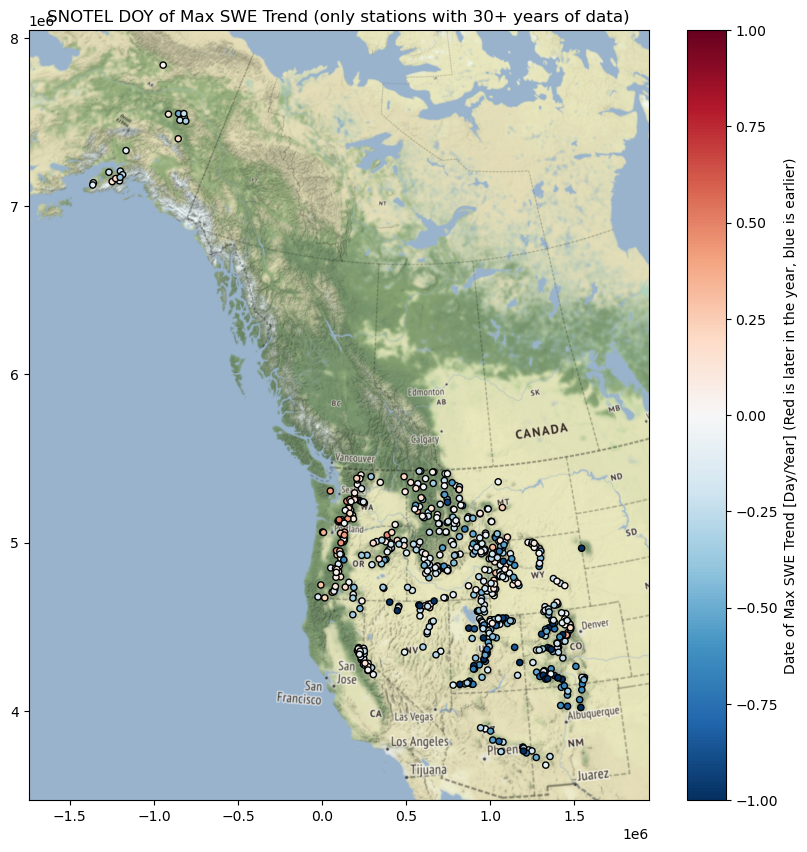

In [18]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='trend',ax=ax,legend=True,cmap='RdBu_r',edgecolor='k',markersize=20,vmin=-1,vmax=1,legend_kwds={'label':'Date of Max SWE Trend [Day/Year] (Red is later in the year, blue is earlier)'})
ax.axis('equal')
ax.set_title('SNOTEL DOY of Max SWE Trend (only stations with 30+ years of data)')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

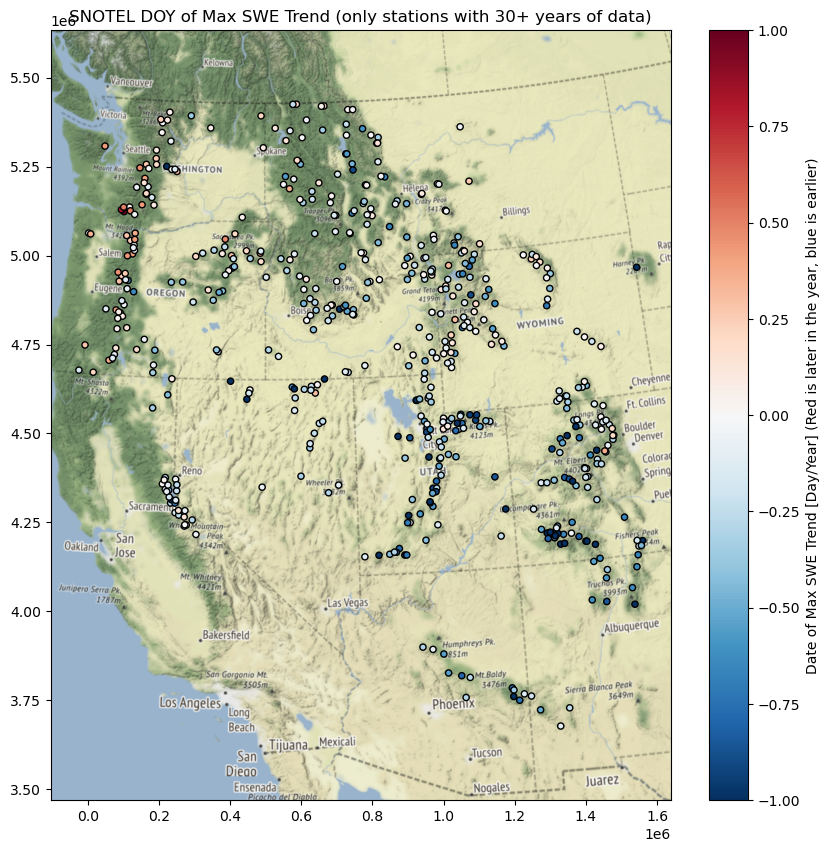

In [19]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected[snotel_gf_projected.state!='Alaska'].plot(column='trend',ax=ax,legend=True,cmap='RdBu_r',edgecolor='k',markersize=20,vmin=-1,vmax=1,legend_kwds={'label':'Date of Max SWE Trend [Day/Year] (Red is later in the year, blue is earlier)'})
ax.axis('equal')
ax.set_title('SNOTEL DOY of Max SWE Trend (only stations with 30+ years of data)')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

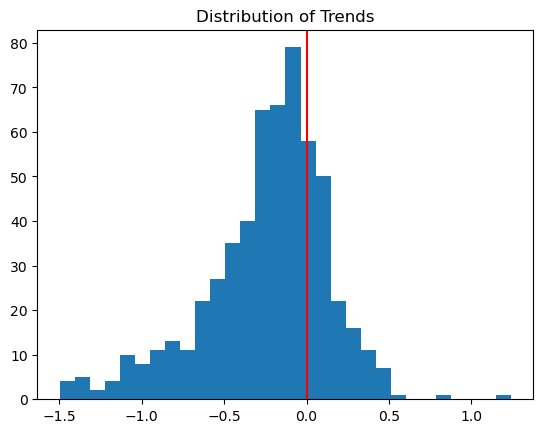

In [20]:
f,ax=plt.subplots()
ax.hist(snotel_gf_projected['trend'],bins=30)
ax.set_title('Distribution of Trends')
ax.axvline(x=0,color='red')

In [160]:
snotel_gf_projected_trends = snotel_gf_projected.groupby('mountainRange').mean()['trend'][snotel_gf_projected.groupby('mountainRange')['trend'].count()>7]

<AxesSubplot:ylabel='mountainRange'>

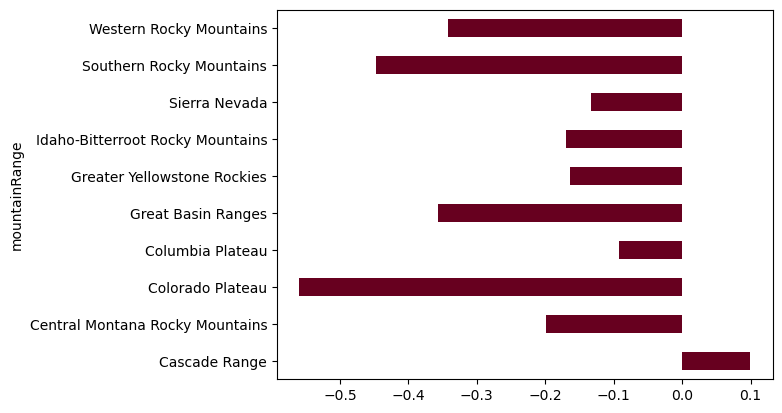

In [161]:
snotel_gf_projected_trends.plot.barh(cmap='RdBu')

In [162]:
dataset = 'GMBA_Inventory_v2.0_standard_300.zip'
url = f'https://data.earthenv.org/mountains/standard/{dataset}'
gf_gmba = gpd.read_file('zip+'+url)
mountains_gf = gf_gmba[gf_gmba.MapName.isin(snotel_gf_projected_trends.index)].sort_values('MapName')

In [163]:
mountains_gf['trend'] = snotel_gf_projected_trends.values

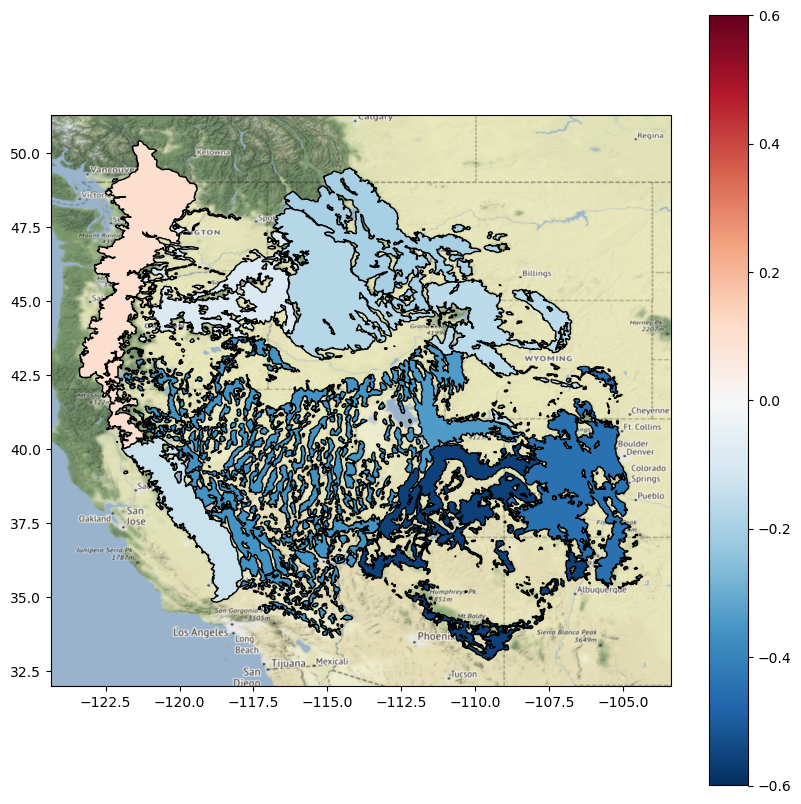

In [164]:
f,ax=plt.subplots(figsize=(10,10))
mountains_gf.plot(ax=ax,vmin=-0.6,vmax=0.6,column='trend',cmap='RdBu_r',legend=True,edgecolor='k')
ctx.add_basemap(ax=ax, crs=mountains_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [21]:
tooltip_list = ['code','name','elevation_m','mean_doy_max_swe','median_doy_max_swe','std_doy_max_swe','trend']

In [22]:
snotel_gf_projected.drop(['beginDate','endDate','isActive'],axis=1).explore(column='trend',cmap='RdBu_r',tooltip=tooltip_list,vmin=-1,vmax=1)

In [23]:
snotel_gf_projected.corr()

elevation_m  latitude  longitude  median_doy_max_swe  \
elevation_m            1.000000 -0.791792   0.829118            0.221179   
latitude              -0.791792  1.000000  -0.847944            0.302750   
longitude              0.829118 -0.847944   1.000000            0.009590   
median_doy_max_swe     0.221179  0.302750   0.009590            1.000000   
mean_doy_max_swe       0.227044  0.301319   0.003401            0.973992   
std_doy_max_swe       -0.098966  0.057537  -0.096302           -0.049414   
trend                 -0.404895  0.344293  -0.278183            0.075772   

                    mean_doy_max_swe  std_doy_max_swe     trend  
elevation_m                 0.227044        -0.098966 -0.404895  
latitude                    0.301319         0.057537  0.344293  
longitude                   0.003401        -0.096302 -0.278183  
median_doy_max_swe          0.973992        -0.049414  0.075772  
mean_doy_max_swe            1.000000         0.115631  0.010221  
std_doy_max_swe             0.115631         1.000000 -0.618262  
trend                       0.010221        -0.618262  1.000000

Text(0.5, 1.0, 'SNOTEL Date of Max SWE Trend vs Elevation')

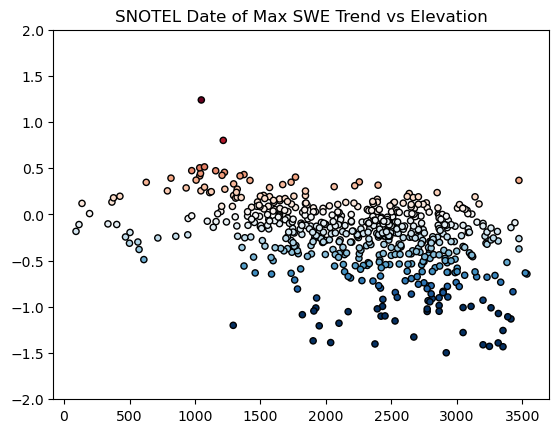

In [132]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['elevation_m'],snotel_gf_projected['trend'],c=snotel_gf_projected['trend'],edgecolor='k',cmap='RdBu_r',s=20,vmin=-1,vmax=1)
ax.set_ylim([-2,2])
ax.set_title('SNOTEL Date of Max SWE Trend vs Elevation')

Text(0.5, 1.0, 'SNOTEL Date of Max SWE Trend vs Latitude')

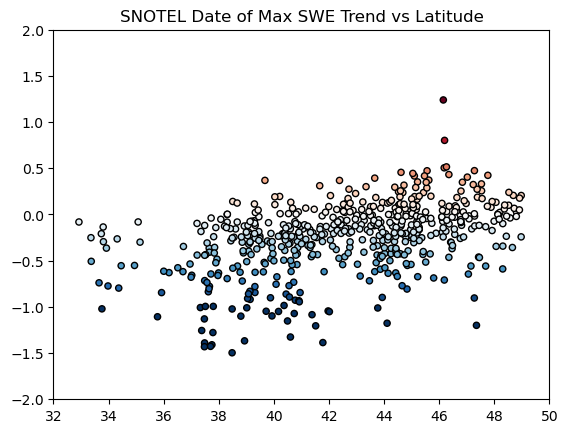

In [25]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['latitude'],snotel_gf_projected['trend'],c=snotel_gf_projected['trend'],edgecolor='k',cmap='RdBu_r',s=20,vmin=-1,vmax=1)
ax.set_ylim([-2,2])
ax.set_xlim([32,50])
ax.set_title('SNOTEL Date of Max SWE Trend vs Latitude')

Text(0.5, 1.0, 'SNOTEL Date of Max SWE Trend vs Longitude')

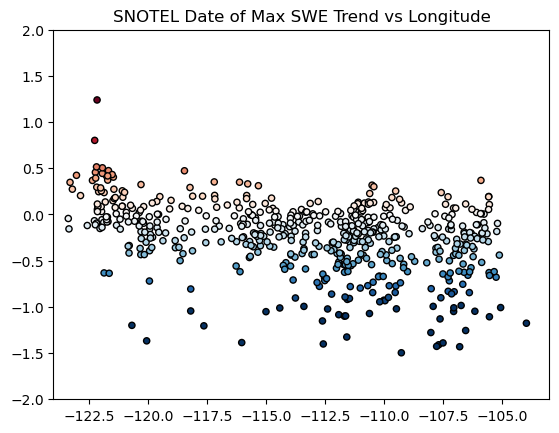

In [26]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['longitude'],snotel_gf_projected['trend'],c=snotel_gf_projected['trend'],edgecolor='k',cmap='RdBu_r',s=20,vmin=-1,vmax=1)
ax.set_ylim([-2,2])
ax.set_xlim([-124,-103])
ax.set_title('SNOTEL Date of Max SWE Trend vs Longitude')

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


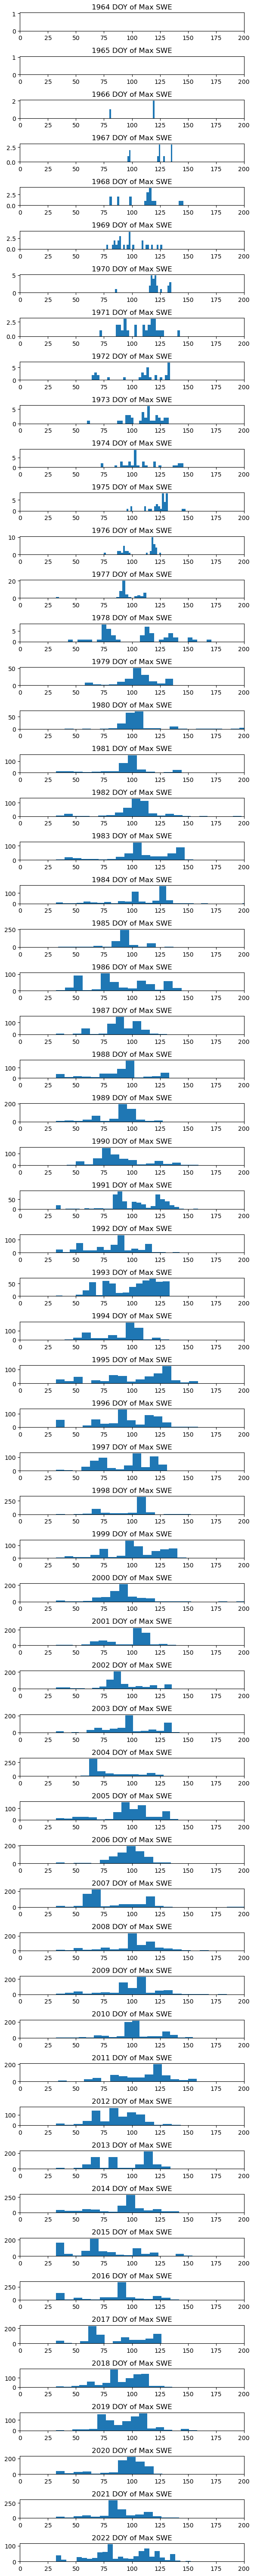

In [27]:
f,ax=plt.subplots(len(years),1,figsize=(6,60))
for year,axs in zip(years,ax.ravel()):
    axs.hist(snotel_gf_projected[f'max_swe_{year}'],bins=30)
    axs.set_title(f'{year} DOY of Max SWE')
    axs.set_xlim([0,200])
    #axs.set_ylim([0,350])
plt.tight_layout()

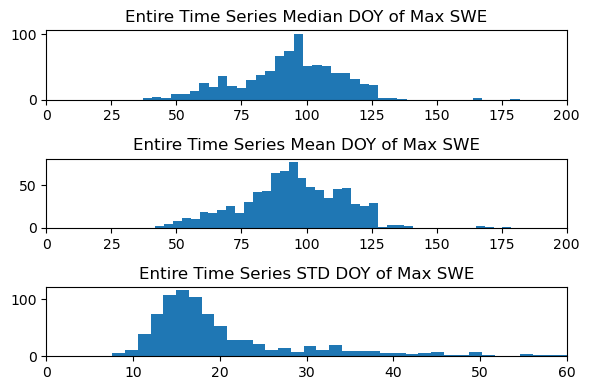

In [28]:
f,ax=plt.subplots(3,1,figsize=(6,4))
ax[0].hist(snotel_gf_projected[f'median_doy_max_swe'],bins=40)
ax[0].set_title(f'Entire Time Series Median DOY of Max SWE')
ax[0].set_xlim([0,200])
ax[1].hist(snotel_gf_projected[f'mean_doy_max_swe'],bins=40)
ax[1].set_title(f'Entire Time Series Mean DOY of Max SWE')
ax[1].set_xlim([0,200])
ax[2].hist(snotel_gf_projected[f'std_doy_max_swe'],bins=60)
ax[2].set_title(f'Entire Time Series STD DOY of Max SWE')
ax[2].set_xlim([0,60])
plt.tight_layout()

In [29]:
snotel_gf_projected.describe()

elevation_m    latitude   longitude  median_doy_max_swe  \
count   868.000000  868.000000  868.000000          834.000000   
mean   2173.990565   43.661984 -115.685892           93.489209   
std     779.290799    6.391633   10.438505           19.284700   
min       7.620000   32.924011 -164.292572           37.000000   
25%    1699.260040   39.591045 -119.563408           83.000000   
50%    2345.283569   42.619249 -112.735241           95.000000   
75%    2750.057922   45.747646 -109.672152          106.500000   
max    3541.775879   70.266663 -103.787582          182.000000   

       mean_doy_max_swe  std_doy_max_swe       trend  
count        834.000000       834.000000  569.000000  
mean          94.394335        20.988580   -0.242060  
std           19.499760        10.767816    0.375529  
min           41.750000         7.620461   -1.496678  
25%           82.600379        14.655831   -0.425370  
50%           94.768360        17.321223   -0.191395  
75%          108.617483        23.056506   -0.003403  
max          178.750000        95.782305    1.239414

In [30]:
snotel_doy_max_swe_gf.describe()

max_swe_1964  max_swe_1965  max_swe_1966  max_swe_1967  max_swe_1968  \
count           1.0           1.0      3.000000     11.000000     18.000000   
mean          118.0         107.0    106.666664    120.181816    109.888885   
std             NaN           NaN     23.094009     15.426070     18.246317   
min           118.0         107.0     80.000000     96.000000     80.000000   
25%           118.0         107.0    100.000000    110.500000     98.250000   
50%           118.0         107.0    120.000000    124.000000    113.000000   
75%           118.0         107.0    120.000000    131.500000    117.000000   
max           118.0         107.0    120.000000    136.000000    146.000000   

       max_swe_1969  max_swe_1970  max_swe_1971  max_swe_1972  max_swe_1973  \
count     24.000000     25.000000     27.000000     33.000000     36.000000   
mean      97.666664    120.919998    107.111115    107.424240    110.472221   
std       13.659418      9.725053     16.525816     24.185518     14.867965   
min       77.000000     85.000000     71.000000     64.000000     60.000000   
25%       87.000000    118.000000     93.000000     92.000000     98.750000   
50%       96.500000    120.000000    111.000000    113.000000    113.000000   
75%      109.250000    122.000000    118.500000    130.000000    121.000000   
max      127.000000    135.000000    143.000000    134.000000    133.000000   

       ...  max_swe_2013  max_swe_2014  max_swe_2015  max_swe_2016  \
count  ...    798.000000    807.000000    819.000000    821.000000   
mean   ...     92.795738     90.936806     73.391945     84.129112   
std    ...     25.760342     26.355511     32.009094     29.139555   
min    ...     32.000000     32.000000     32.000000     32.000000   
25%    ...     69.000000     74.500000     57.000000     75.000000   
50%    ...     87.000000     96.000000     65.000000     90.000000   
75%    ...    113.000000     99.000000    101.500000     93.000000   
max    ...    268.000000    268.000000    261.000000    268.000000   

       max_swe_2017  max_swe_2018  max_swe_2019  max_swe_2020  max_swe_2021  \
count    826.000000    825.000000    831.000000    831.000000    833.000000   
mean      86.346245     92.504242     94.700363     92.974731     89.428574   
std       26.116323     19.446224     21.605631     22.592899     20.912807   
min       32.000000     32.000000     32.000000     32.000000     32.000000   
25%       67.000000     83.000000     77.000000     90.000000     85.000000   
50%       74.000000     95.000000     95.000000     97.000000     87.000000   
75%      110.000000    108.000000    107.000000    108.000000    102.000000   
max      250.000000    240.000000    255.000000    270.000000    268.000000   

       max_swe_2022  
count    833.000000  
mean      92.774307  
std       27.818567  
min       32.000000  
25%       75.000000  
50%       92.000000  
75%      114.000000  
max      171.000000  

[8 rows x 59 columns]

In [31]:
column_names = {list(snotel_doy_max_swe_gf.columns)[i]: years[i] for i in range(len(years))}

In [32]:
flattened = pd.melt(snotel_doy_max_swe_gf.rename(columns=column_names).T.reset_index().rename(columns={'index':'year'}),id_vars='year')

In [33]:
flattened = flattened.dropna()
#flattened = flattened[flattened.year>2017]

In [34]:
slope,intercept = np.polyfit(flattened.year,flattened.value,1)

In [35]:
#import seaborn as sns

In [36]:
#f,ax=plt.subplots(figsize=(30,5))
#ax.plot(years,np.array(years)*slope+intercept,'k--',label=f'Trend (slope={slope:.2f} Days/Year)')
#flattened.plot.scatter(x='year',y='value',ax=ax)
#sns.violinplot(ax=ax,data=flattened,x='year',y='value')
#ax.set_ylim([60,140])

In [37]:
#slope,intercept = np.polyfit(years,snotel_doy_max_swe_gf.describe().loc['mean'],1)

Text(0.5, 1.0, 'SNOTEL DOY of Max SWE (all stations)')

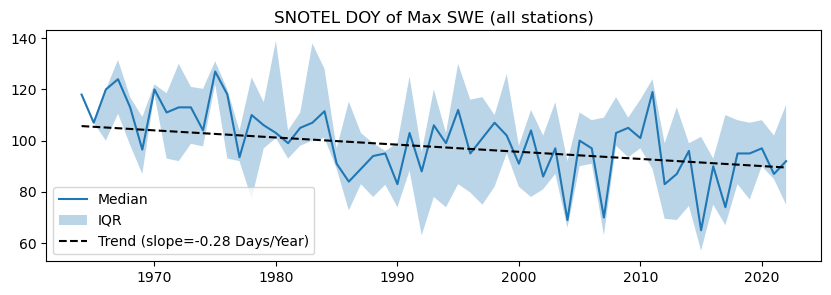

In [38]:
f,ax=plt.subplots(figsize=(10,3))
#ax.scatter(x=years,y=snotel_doy_max_swe_gf.describe().loc['50%'])
#ax.scatter(x=years,y=snotel_doy_max_swe_gf.describe().loc['25%'])
#ax.scatter(x=years,y=snotel_doy_max_swe_gf.describe().loc['75%'])
ax.plot(years,snotel_doy_max_swe_gf.describe().loc['50%'],label='Median')
ax.fill_between(years,snotel_doy_max_swe_gf.describe().loc['25%'],snotel_doy_max_swe_gf.describe().loc['75%'],alpha=0.3,label='IQR')
ax.plot(years,np.array(years)*slope+intercept,'k--',label=f'Trend (slope={slope:.2f} Days/Year)')
ax.legend()
ax.set_title('SNOTEL DOY of Max SWE (all stations)')

#.plot(ax=ax)
#snotel_doy_max_swe_gf.describe().loc['mean'].plot(ax=ax)

Text(0, 0.5, 'Number of active stations')

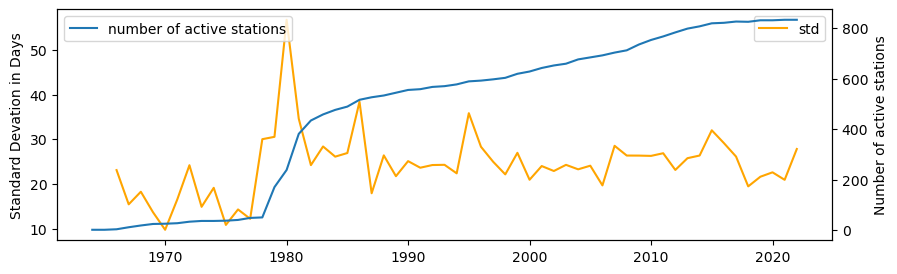

In [39]:
f,ax=plt.subplots(figsize=(10,3))
count_ax = ax.twinx()
count_ax.plot(years,snotel_doy_max_swe_gf.describe().loc['count'],label='number of active stations')
ax.plot(years,snotel_doy_max_swe_gf.describe().loc['std'],label='std',color='orange')
ax.legend()
count_ax.legend()
ax.set_ylabel('Standard Devation in Days')
count_ax.set_ylabel('Number of active stations')

In [40]:
import statsmodels.api as sm
X2 = sm.add_constant(flattened.year)
mod = sm.OLS(flattened.value,X2)
fii = mod.fit()
p_values = fii.summary2()

In [41]:
p_values

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.016      
Dependent Variable: value            AIC:                267372.8229
Date:               2023-02-28 21:21 BIC:                267389.3236
No. Observations:   28292            Log-Likelihood:     -1.3368e+05
Df Model:           1                F-statistic:        465.3      
Df Residuals:       28290            Prob (F-statistic): 2.21e-102  
R-squared:          0.016            Scale:              744.36     
----------------------------------------------------------------------
          Coef.     Std.Err.      t       P>|t|     [0.025     0.975] 
----------------------------------------------------------------------
const    653.4088    25.8958    25.2322   0.0000   602.6518   704.1658
year      -0.2789     0.0129   -21.5719   0.0000    -0.3042    -0.2535
--------------------------------------------------------------------
Omnibus:              6543.937      Durbin-Watson:         1.123    
Prob(Omnibus):        0.000         Jarque-Bera (JB):      46433.560
Skew:                 0.929         Prob(JB):              0.000    
Kurtosis:             8.995         Condition No.:         319795   
====================================================================
* The condition number is large (3e+05). This might indicate
strong multicollinearity or other numerical problems.
"""